Compare the magnitudes produced by tractor to the magnitudes produced by the curve of growth

In [1]:
from glob import glob
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import matplotlib


In [2]:
data_path = '/Users/matt/Data/legacydata/sv3-clustering/raw_output/'
ellipse_nm = 'total_ellipse.fits'
tractor_nm = 'total_tractor.fits'
sample_nm = 'total_sample.fits'

In [3]:
mag_bins = np.array([12.06, 12.804, 13.548, 14.292, 15.036, 15.78, 16.524, 17.268, 18.012, 18.756, 19.49992683], dtype=np.float64)

def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

flux_bins = mag_to_flux(mag_bins)

In [4]:
tractor = Table.read(data_path+tractor_nm)
ellipse = Table.read(data_path+ellipse_nm)
sample = Table.read(data_path+sample_nm)

In [5]:
print(np.all(tractor['ref_id'] == ellipse['ID_CENT']))
print(np.all(tractor['ref_id'] == sample['TARGETID']))

True
True


In [6]:
def get_mags(cat, bands=["g", "r", "z"], pipeline=False, cog=False):
    res = []
    for band in bands:
        mag = None
        ff = 0
        if pipeline:
            iv = cat["flux_ivar_{}".format(band).lower()]
            ff = cat["flux_{}".format(band).lower()]
        elif cog:
            mag = cat["cog_mtot_{}".format(band).upper()]

        if mag:
            res.append("{:.3f}".format(mag))
        else:
            if ff > 0:
                mag = 22.5 - 2.5 * np.log10(ff)
                if iv > 0:
                    ee = 1 / np.sqrt(iv)
                    magerr = 2.5 * ee / ff / np.log(10)
                res.append("{:.3f}".format(mag))
            elif ff < 0 and iv > 0:
                # upper limit
                mag = 22.5 - 2.5 * np.log10(1 / np.sqrt(iv))
                res.append(">{:.3f}".format(mag))
            else:
                res.append('0')
    return res

In [7]:
# all_cats = list(zip(tractor, sample, ellipse))
# mask = (tractor['shape_r'] >= 1)
# tractor = tractor[mask]
# sample = sample[mask]
# ellipse = ellipse[mask]

In [8]:
grz_trac = [get_mags(t, pipeline=True) for t in tractor]
grz_trac = np.array(list(zip(*grz_trac)), dtype=np.float64)

grz_cog = np.array([get_mags(e, cog=True) for e in ellipse], dtype=np.float64)
grz_cog = np.array(list(zip(*grz_cog)), dtype=np.float64)

r_mag = flux_to_mag(sample['FLUX_R_DERED'])
r_flux = sample['FLUX_R_DERED']
z = sample['Z']
ra = sample['RA']
dec = sample['DEC']
r_mosaic = sample['RADIUS_MOSAIC']
ref_id = sample['TARGETID']

delta_mag_r_tractor = grz_cog[1] - grz_trac[1]
delta_mag_r = grz_cog[1] - r_mag

In [9]:
print(len(delta_mag_r[np.abs(delta_mag_r) > 5]))
print(sample[np.abs(delta_mag_r) > 3]['TARGETID'])

2
     TARGETID    
-----------------
39627764248087271
39628433268934789
39627800377820319
39628411747961568
39628362649439929
39627860868073046
39628427900228087


### Taking a look at residuals as a function of magnitude

(-3.0, 1.0)

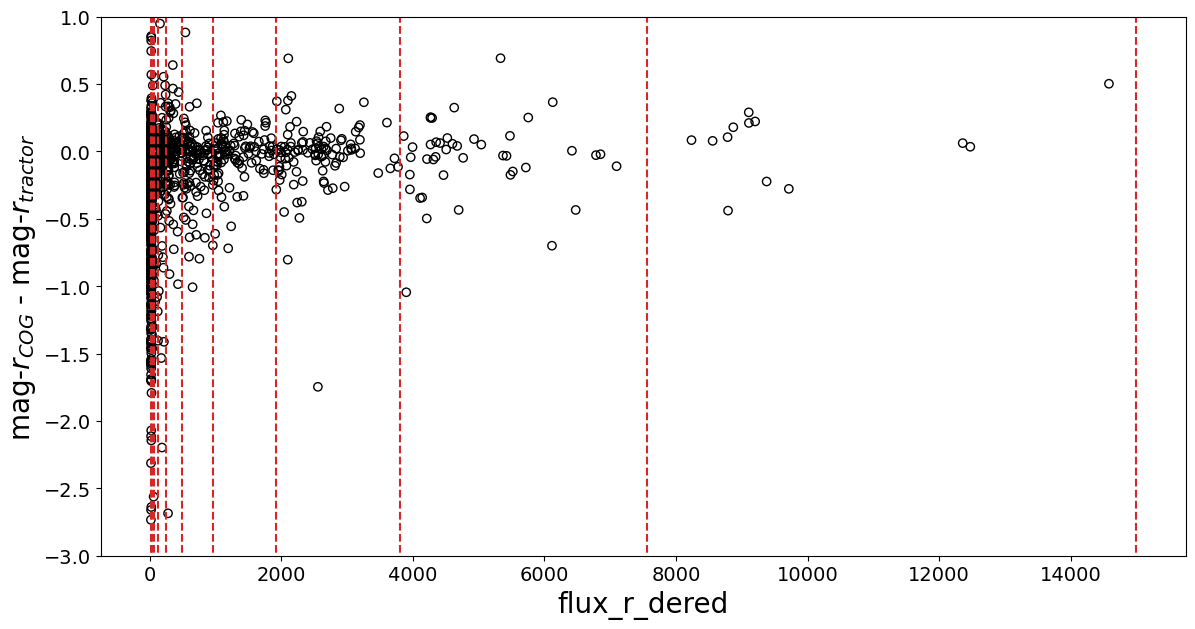

In [10]:
plt.figure(figsize=(14,7))

plt.scatter(r_flux, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.xlabel('flux_r_dered', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.vlines(flux_bins, -4, 4, ls='dashed', color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3,1)

In [31]:
def plot_data_and_sem(ax1, ax2, delta_mag_r, x_values, x_bins):
    # Simple scatter plot of all values
    ax1.scatter(x_values, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
    ax1.hlines(0, 0, 100000, ls='dashed', color='tab:red')
    ax1.vlines(x_bins, -20, 20, ls='dashed', color='tab:red')
    ax1.set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)

    # Calculate the stats in the bins
    mean = []
    std = []
    mid_pt = []
    binned_sample = []
    stdem = []
    for i in range(len(x_bins)-1):
        this_bin_low = x_values > x_bins[i]
        this_bin_max = x_values <= x_bins[i+1]
        
        mask = np.all([this_bin_low.flatten(), this_bin_max.flatten()], axis=0)
        this_bin = delta_mag_r[mask]
        
        binned_sample.append(this_bin)
        mean.append(np.mean(this_bin))
        std.append(np.std(this_bin))
        stdem.append(sem(this_bin))
        mid_pt.append((x_bins[i+1]+  x_bins[i])/2)

    # Plot the mean/stdem
    ax2.errorbar(mid_pt, mean, stdem, marker='o', lw=1, c='k', linestyle='none', 
        capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
    ax2.hlines(0, 0, 100000, ls='dashed', color='tab:red')
    ax2.vlines(x_bins, -10, 10, ls='dashed', color='tab:red')
    ax2.set_ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
    ax2.set_ylim(-1.5,1)

    for i in range(len(binned_sample)):
        n = len(binned_sample[i])
        mid_pt[i]
        ax2.annotate(f'N={n}', xy=(mid_pt[i], .65), xycoords='data', horizontalalignment='center', fontsize=10)

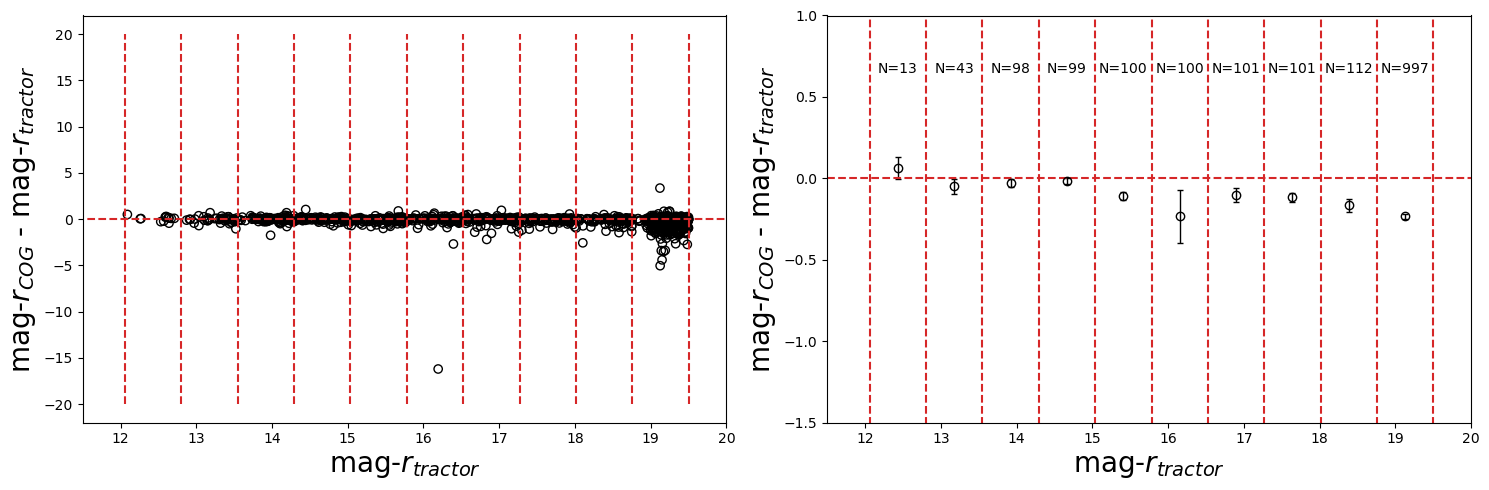

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plot_data_and_sem(ax1, ax2, delta_mag_r, r_mag, mag_bins)

ax1.set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
ax1.set_xlim(11.5, 20)
ax2.set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
ax2.set_xlim(11.5, 20)

fig.tight_layout()

### Now looking at residuals as a function of redshift

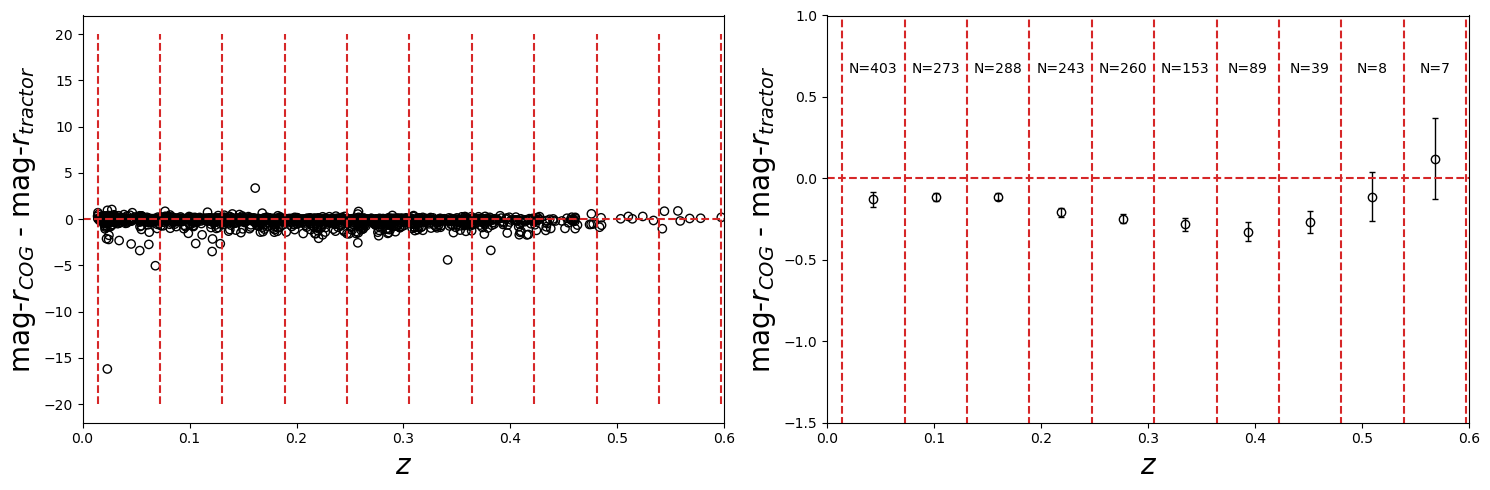

In [13]:
col_min = min(z); col_max = max(z)
z_bins = np.linspace(col_min, col_max, 11).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plot_data_and_sem(ax1, ax2, delta_mag_r, z, z_bins)

ax1.set_xlabel(r'$z$', fontsize=20)
ax1.set_xlim(0, .6)
ax2.set_xlabel(r'$z$', fontsize=20)
ax2.set_xlim(0, .6)

fig.tight_layout()

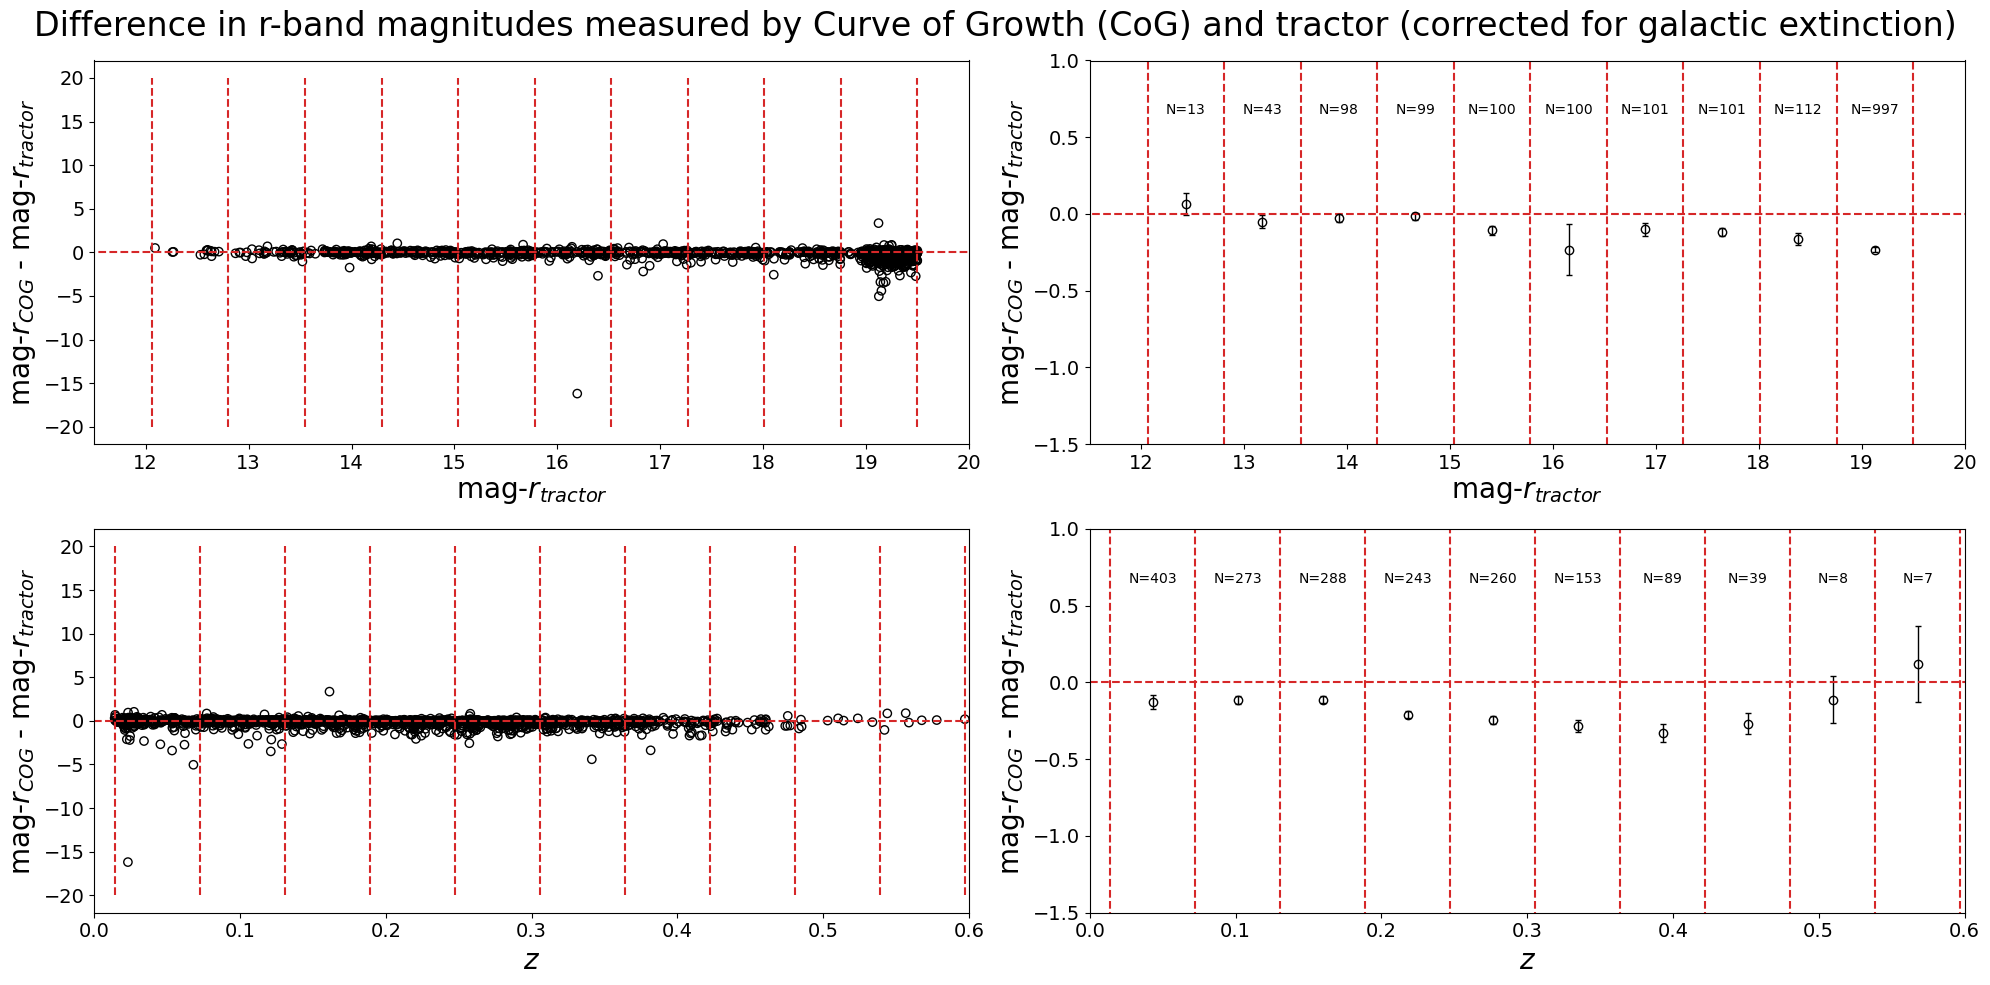

In [14]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('figure', facecolor='white')

fig, (row1, row2) = plt.subplots(2, 2, figsize=(20,10))

plot_data_and_sem(row1[0], row1[1], delta_mag_r, r_mag, mag_bins)
row1[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[0].set_xlim(11.5, 20)
row1[1].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[1].set_xlim(11.5, 20)


plot_data_and_sem(row2[0], row2[1], delta_mag_r, z, z_bins)
row2[0].set_xlabel(r'$z$', fontsize=20)
row2[0].set_xlim(0, .6)
row2[1].set_xlabel(r'$z$', fontsize=20)
row2[1].set_xlim(0, .6)


fig.suptitle('Difference in r-band magnitudes measured by Curve of Growth (CoG) and tractor (corrected for galactic extinction)', fontsize=24)
plt.tight_layout()

### Looking at residuals as a function of redshift and magnitude, in a 2d plane

In [15]:
import matplotlib.pyplot as plt
z = z.flatten()

grid_size=15
z_grid = np.linspace(z.min(), z.max(), grid_size)
mag_grid = np.linspace(r_mag.min(), r_mag.max(), grid_size)

avg_binned = []

for i in range(len(z_grid)-1):
    
    # For a z_bin
    z_bin = z_grid[i]; z_bin_next = z_grid[i+1]
    
    for j in range(len(mag_grid)-1):
    
        # for a mag bin
        mag_bin = mag_grid[j]; mag_bin_next = mag_grid[j+1]
        
        # Loop over all (z, mag, delta-mag-r) combos, add any in this bin into a list    
        delta_mag_r_this_bin = []
        for trio in list(zip(z, r_mag, delta_mag_r)):
            if trio[0] > z_bin and trio[0] < z_bin_next and trio[1] > mag_bin and trio[1] < mag_bin_next:
                delta_mag_r_this_bin.append(trio[2])
        
        # Average all valid guys 
        mag_midpt = (mag_bin+mag_bin_next)/2
        z_midpt = (z_bin+z_bin_next)/2
        mean_delta_mag_r = np.nan
        if len(delta_mag_r_this_bin) > 0:
            mean_delta_mag_r = np.mean(delta_mag_r_this_bin)

        avg_binned.append((z_midpt, mag_midpt, mean_delta_mag_r))

z_rebin, m_rebin, delta_mag_rebin = list(zip(*avg_binned))

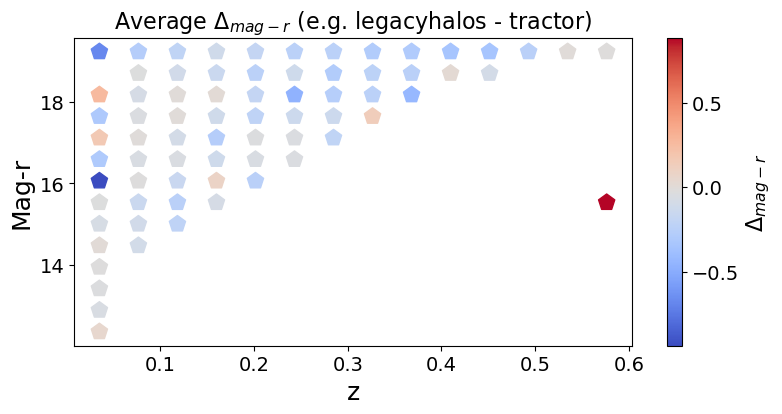

In [16]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))
sc = ax0.scatter(z_rebin, m_rebin, 150, c=delta_mag_rebin, marker='p', cmap='coolwarm')


# xlim = z.min()-0.1, z.max()+0.1
# ylim = mag.min()-2, mag.max()+2
# hb = ax0.hexbin(z, mag, gridsize=15, cmap='inferno')
# ax0.set(xlim=xlim, ylim=ylim)

cb = fig.colorbar(sc, ax=ax0)
cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
plt.xlabel('z', fontsize=18)
plt.ylabel('Mag-r', fontsize=18)
plt.title(r'Average $\Delta_{mag-r}$ (e.g. legacyhalos - tractor)', fontsize=16)
plt.show()


### Now residuals as a function of:
* Size
* Magnitude
* Color
* Type 
  * Morphological Type
  * Sersic Index
* Ellipticity
* Crowdedness / Density

First let's look at tractor residuals: sersic, shape, PA, and ellipticity

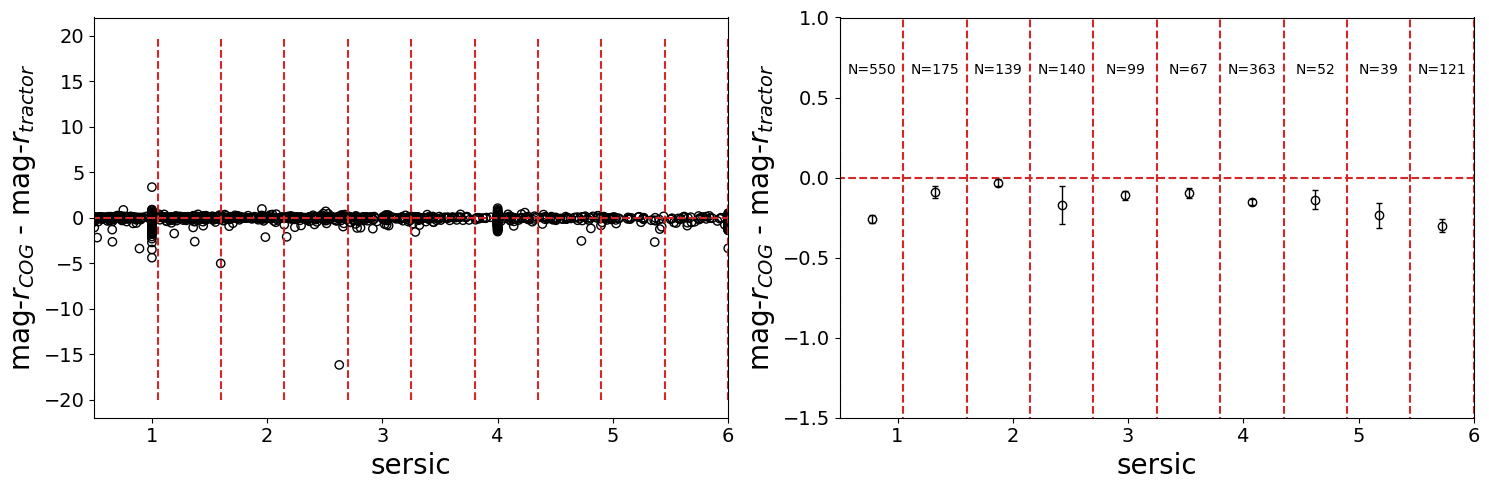

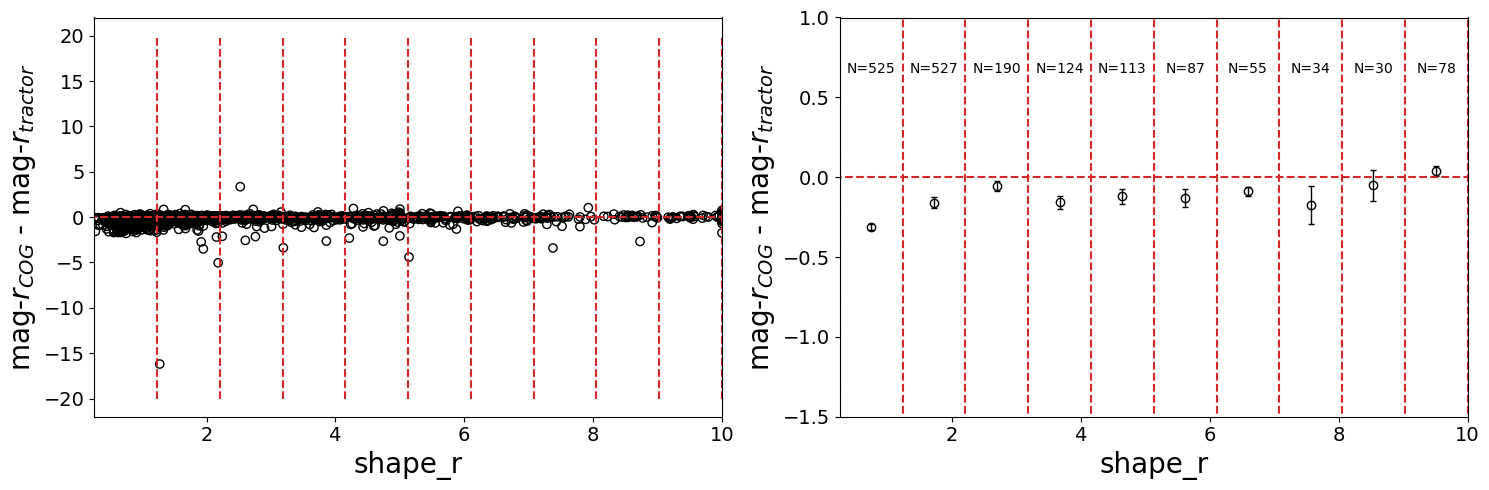

In [32]:
tractor_columns = ['sersic', 'shape_r']

for tc in tractor_columns:
    col_data = tractor[tc]
    col_min = min(col_data); col_max = max(col_data)
    col_bins = np.linspace(col_min, col_max, 11).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    plot_data_and_sem(ax1, ax2, delta_mag_r, col_data, col_bins)

    ax1.set_xlabel(tc, fontsize=20)
    ax1.set_xlim(col_min, col_max)
    ax2.set_xlabel(tc, fontsize=20)
    ax2.set_xlim(col_min, col_max)

    fig.tight_layout()

And derived columns of PA and e

In [35]:
ee = np.hypot(tractor["shape_e1"], tractor["shape_e2"])
ba = (1 - ee) / (1 + ee)
pa = 180 - (
    -np.rad2deg(np.arctan2(tractor["shape_e2"], tractor["shape_e1"]) / 2)
)
pa = pa % 180
e = 1-ba


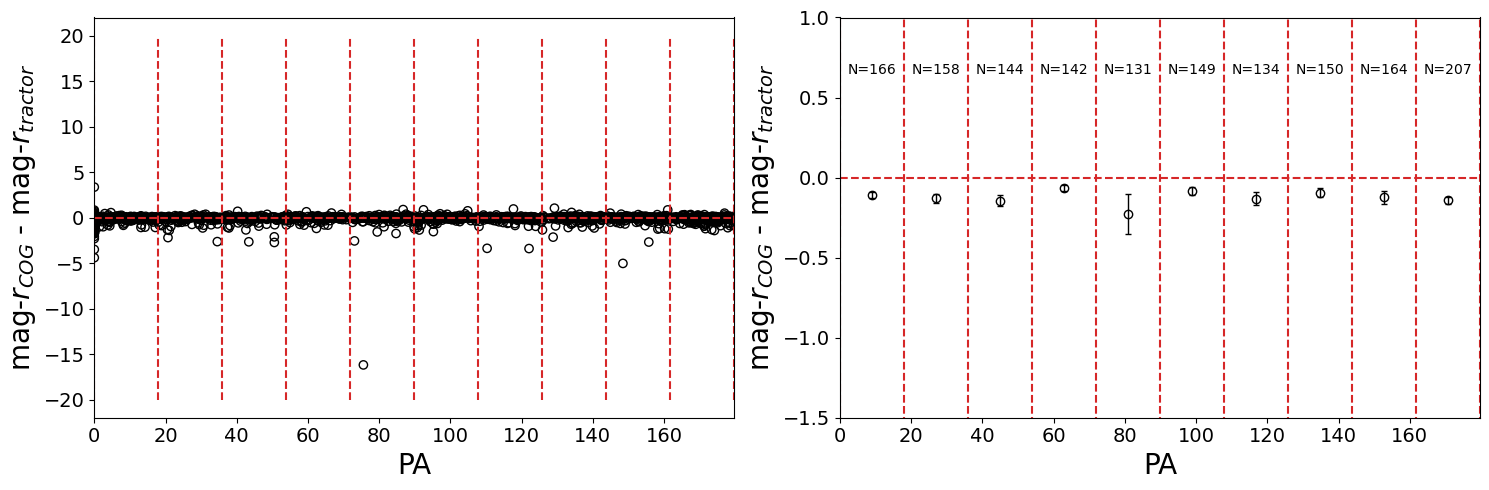

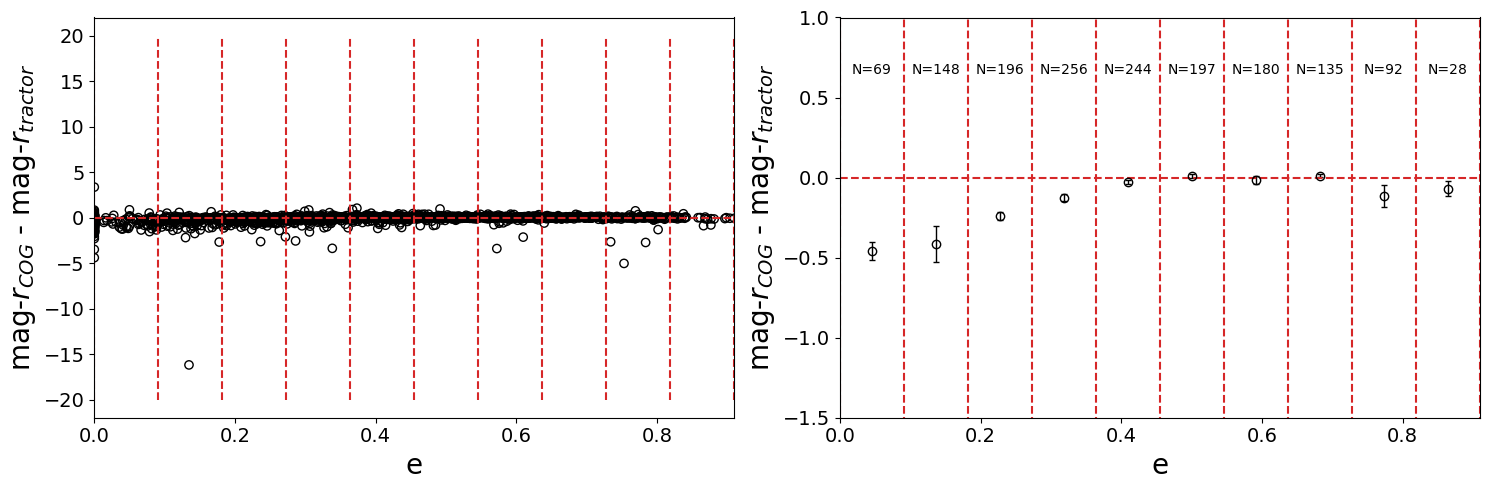

In [37]:
tlbl = ['PA', 'e']
i = 0
for col_data in [pa, e]:
    col_min = min(col_data); col_max = max(col_data)
    col_bins = np.linspace(col_min, col_max, 11).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    plot_data_and_sem(ax1, ax2, delta_mag_r, col_data, col_bins)

    ax1.set_xlabel(tlbl[i], fontsize=20)
    ax1.set_xlim(col_min, col_max)
    ax2.set_xlabel(tlbl[i], fontsize=20)
    ax2.set_xlim(col_min, col_max)
    i+=1
    fig.tight_layout()

Now look at the ellipsefit parameter residuals

In [38]:
ellipse_cols = ['sma_moment', 'pa_moment', 'eps_moment', 'cog_sma50_r']

/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3462: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,


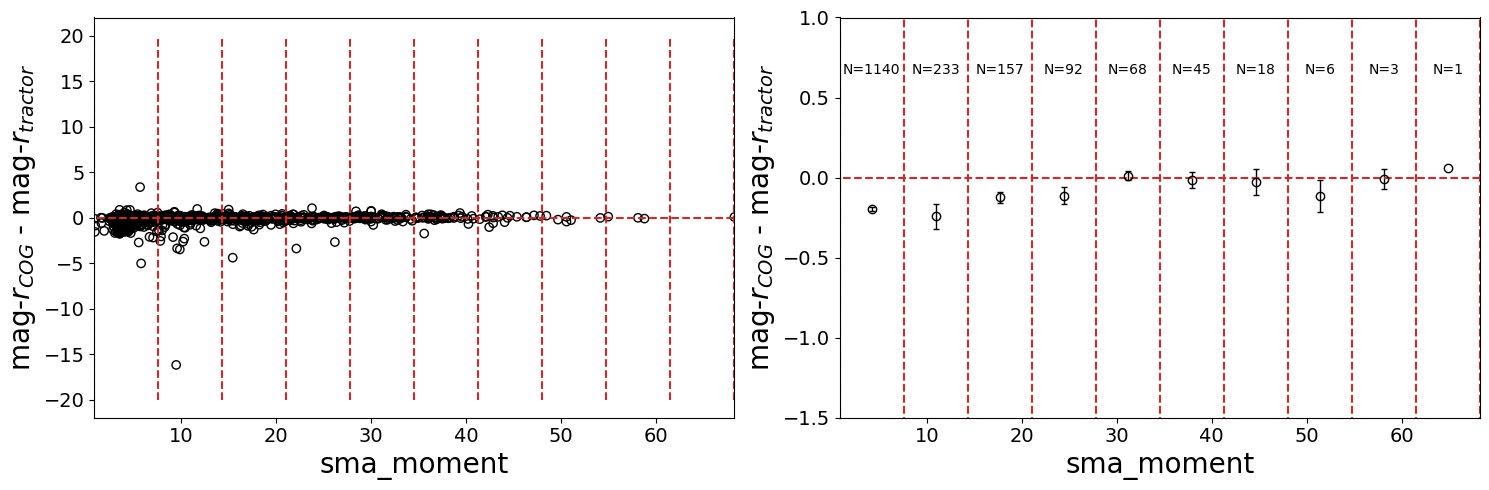

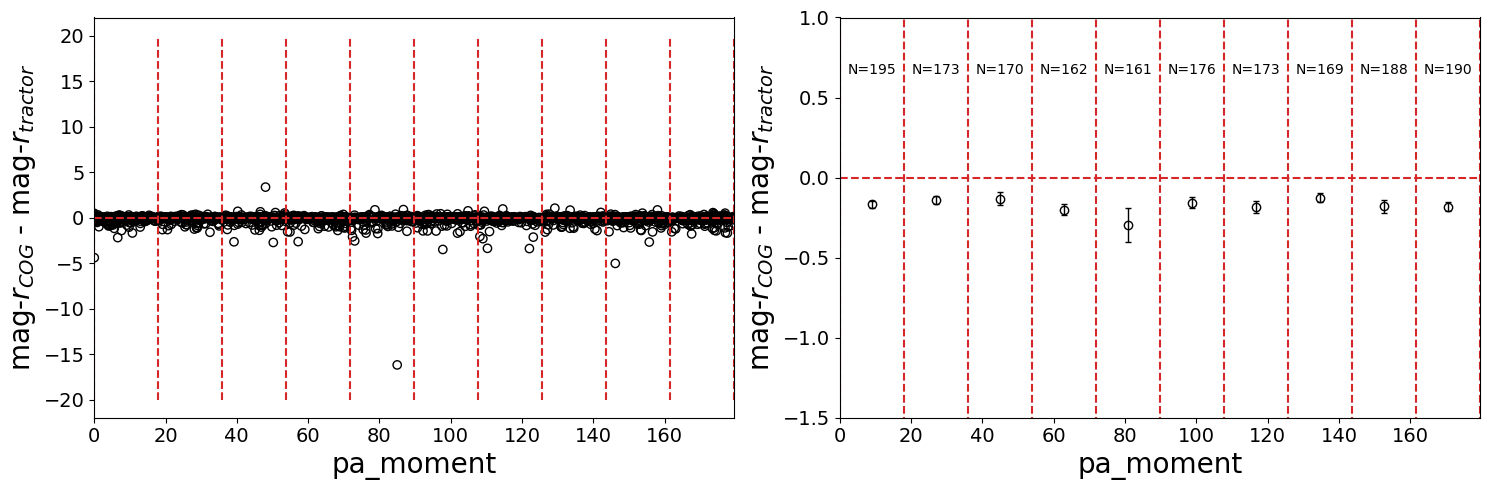

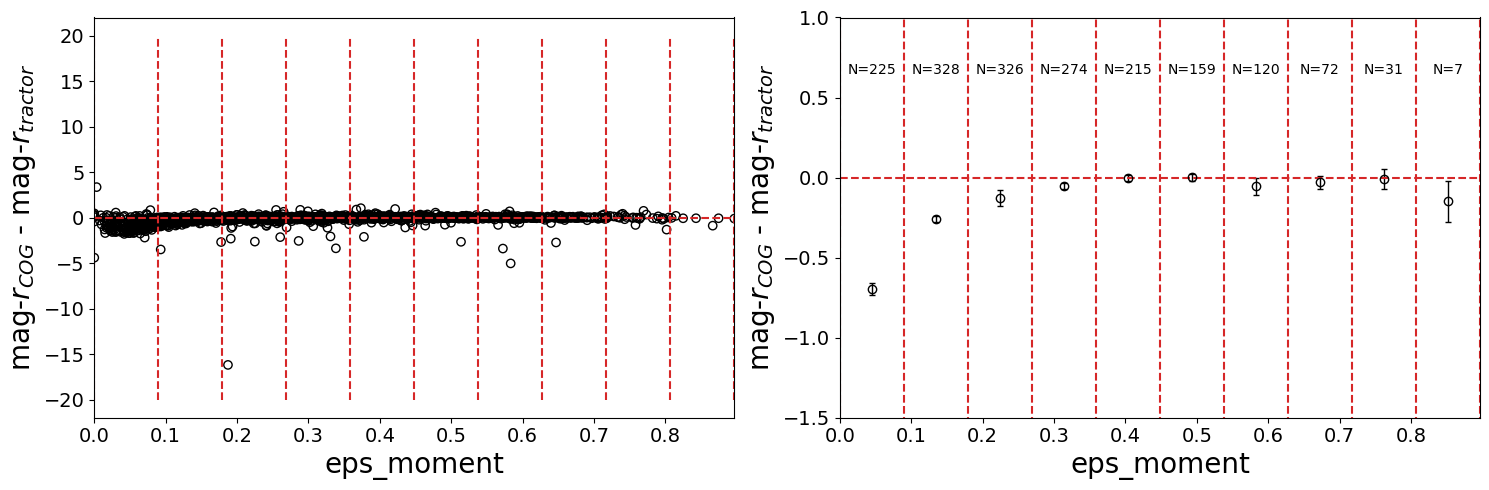

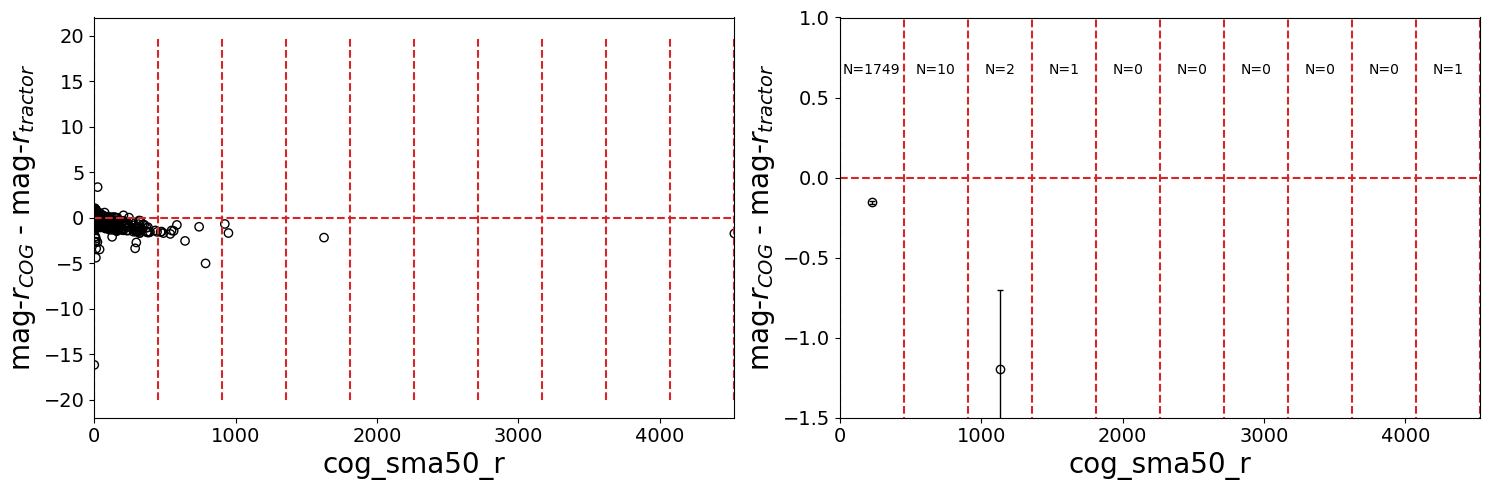

In [41]:
for ec in ellipse_cols:
    col_data = ellipse[ec.upper()]
    col_min = min(col_data); col_max = max(col_data)
    col_bins = np.linspace(col_min, col_max, 11).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    plot_data_and_sem(ax1, ax2, delta_mag_r, col_data, col_bins)

    ax1.set_xlabel(ec, fontsize=20)
    ax1.set_xlim(col_min, col_max)
    ax2.set_xlabel(ec, fontsize=20)
    ax2.set_xlim(col_min, col_max)

    fig.tight_layout()